In [1]:
# inizializziamo la SparkSession e importiamo le librerie
import findspark
import seaborn as sns
import matplotlib.pyplot as plt


location = findspark.find()
findspark.init(location)

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.functions import col
import pyspark.sql.functions as f

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, VectorIndexer



spark = SparkSession \
    .builder \
    .appName("Houses Price") \
    .getOrCreate()

In [2]:
# Carichiamo il data set
trainDF = spark.read.csv('hdfs://localhost:9000/user/vito/input/train.csv', header = 'True', inferSchema='True', nullValue='NA')
testDF = spark.read.csv('hdfs://localhost:9000/user/vito/input/test.csv', header = 'True', inferSchema='True', nullValue='NA')

In [3]:
trainDF.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- MSSubClass: integer (nullable = true)
 |-- MSZoning: string (nullable = true)
 |-- LotFrontage: integer (nullable = true)
 |-- LotArea: integer (nullable = true)
 |-- Street: string (nullable = true)
 |-- Alley: string (nullable = true)
 |-- LotShape: string (nullable = true)
 |-- LandContour: string (nullable = true)
 |-- Utilities: string (nullable = true)
 |-- LotConfig: string (nullable = true)
 |-- LandSlope: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- Condition2: string (nullable = true)
 |-- BldgType: string (nullable = true)
 |-- HouseStyle: string (nullable = true)
 |-- OverallQual: integer (nullable = true)
 |-- OverallCond: integer (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- YearRemodAdd: integer (nullable = true)
 |-- RoofStyle: string (nullable = true)
 |-- RoofMatl: string (nullable = true)
 |-- Exterior1st: string (nullable = true)
 |-

In [4]:
# creo un UDF per contare il numero di elementi nulli all'interno del dataframe divisi per colonna

def null_value_count(df):
  null_columns_counts = []
  for k in df.columns:
    nullRows = df.where(col(k).isNull()).count()
    if(nullRows > 0):
      temp = k,nullRows
      null_columns_counts.append(temp)
  return(null_columns_counts)

In [5]:
nullFeaturesTrainDF = spark.createDataFrame(null_value_count(trainDF), ['TRAIN Features with NA value', 'Count']).sort('Count', ascending=False)
nullFeaturesTrainDF.show()

+----------------------------+-----+
|TRAIN Features with NA value|Count|
+----------------------------+-----+
|                      PoolQC| 1453|
|                 MiscFeature| 1406|
|                       Alley| 1369|
|                       Fence| 1179|
|                 FireplaceQu|  690|
|                 LotFrontage|  259|
|                  GarageQual|   81|
|                 GarageYrBlt|   81|
|                  GarageType|   81|
|                GarageFinish|   81|
|                  GarageCond|   81|
|                BsmtExposure|   38|
|                BsmtFinType2|   38|
|                    BsmtCond|   37|
|                    BsmtQual|   37|
|                BsmtFinType1|   37|
|                  MasVnrType|    8|
|                  MasVnrArea|    8|
|                  Electrical|    1|
+----------------------------+-----+



In [6]:
# calcolo la percentuale di dati mancanti

nullFeaturesTrainDF = nullFeaturesTrainDF.withColumn( "Missing Ratio",  col("Count") / trainDF.count() * 100)
nullFeaturesTrainDF.show()

+----------------------------+-----+------------------+
|TRAIN Features with NA value|Count|     Missing Ratio|
+----------------------------+-----+------------------+
|                      PoolQC| 1453| 99.52054794520548|
|                 MiscFeature| 1406| 96.30136986301369|
|                       Alley| 1369| 93.76712328767123|
|                       Fence| 1179| 80.75342465753424|
|                 FireplaceQu|  690| 47.26027397260274|
|                 LotFrontage|  259| 17.73972602739726|
|                 GarageYrBlt|   81|5.5479452054794525|
|                  GarageQual|   81|5.5479452054794525|
|                GarageFinish|   81|5.5479452054794525|
|                  GarageType|   81|5.5479452054794525|
|                  GarageCond|   81|5.5479452054794525|
|                BsmtExposure|   38|2.6027397260273974|
|                BsmtFinType2|   38|2.6027397260273974|
|                BsmtFinType1|   37|2.5342465753424657|
|                    BsmtQual|   37|2.5342465753

Text(0.5, 1.0, 'Percentuale di valori mancanti per ogni feature')

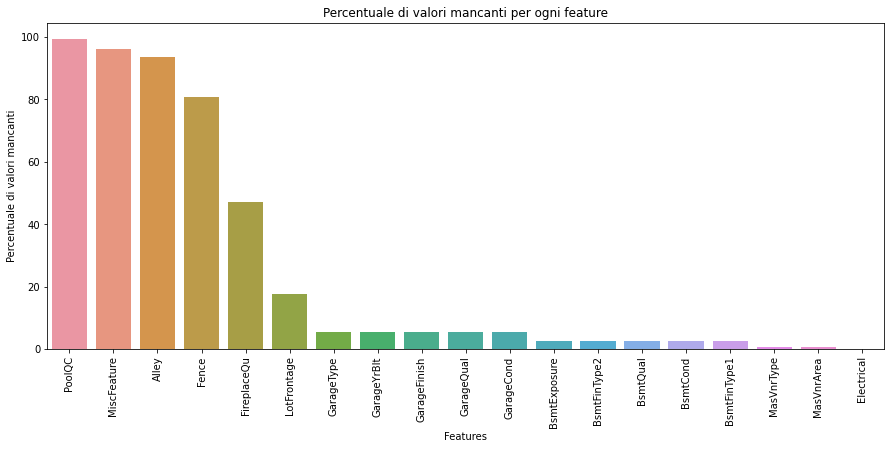

In [7]:
# facciamo un grafico per capire meglio
df_TrainPD = nullFeaturesTrainDF.toPandas()

plt.subplots(figsize=(15, 6))
plt.xticks(rotation='90')
sns.barplot(x=df_TrainPD['TRAIN Features with NA value'], y=df_TrainPD['Missing Ratio']) 
plt.xlabel('Features')
plt.ylabel('Percentuale di valori mancanti')
plt.title('Percentuale di valori mancanti per ogni feature')

In [8]:
# cancelliamo le features che hanno una percentuale di valori nulli sopra 80%
dropFeatures = df_TrainPD['TRAIN Features with NA value'][ df_TrainPD['Missing Ratio'] > 80 ] 
print(f'Lista delle features da cancellare:\n{dropFeatures}')

trainDF = trainDF.drop(*dropFeatures)

Lista delle features da cancellare:
0         PoolQC
1    MiscFeature
2          Alley
3          Fence
Name: TRAIN Features with NA value, dtype: object


In [9]:
#cancelliamo le feature droppate anche nel test set
train_cols = list(trainDF.columns)
train_cols.remove('SalePrice')

testDF = testDF[train_cols]

In [10]:
# controlliamo le feature mancanti anche nel test set
nullFeaturesTestDF = spark.createDataFrame(null_value_count(testDF), ['TEST Features with NA value', 'Count']).sort('Count', ascending=False)
nullFeaturesTestDF.show()

+---------------------------+-----+
|TEST Features with NA value|Count|
+---------------------------+-----+
|                FireplaceQu|  730|
|                LotFrontage|  227|
|                 GarageQual|   78|
|                 GarageCond|   78|
|               GarageFinish|   78|
|                GarageYrBlt|   78|
|                 GarageType|   76|
|                   BsmtCond|   45|
|                   BsmtQual|   44|
|               BsmtExposure|   44|
|               BsmtFinType2|   42|
|               BsmtFinType1|   42|
|                 MasVnrType|   16|
|                 MasVnrArea|   15|
|                   MSZoning|    4|
|               BsmtHalfBath|    2|
|                  Utilities|    2|
|               BsmtFullBath|    2|
|                 Functional|    2|
|                Exterior1st|    1|
+---------------------------+-----+
only showing top 20 rows



In [11]:
# controlliamo se le righe in cui il fireplaces è 0 e il valore di fireplaceQu è NA coincida (690 per il train e 730 per il test)
train_fireplaceQu_count = trainDF.where( ( col('FireplaceQu').isNull() == True) & ( col('Fireplaces') == 0 ) ).count()
test_fireplaceQu_count = testDF.where( ( col('FireplaceQu').isNull() == True) & ( col('Fireplaces') == 0 ) ).count()

print(f'FireplaceQu nel train: {train_fireplaceQu_count}\nFireplaceQu nel test: {test_fireplaceQu_count}\n')

FireplaceQu nel train: 690
FireplaceQu nel test: 730



In [12]:
# settiamo la feature FireplaceQu = 'None'

trainDF = trainDF.withColumn("FireplaceQu", when( ( col('FireplaceQu').isNull() == True) & ( col('Fireplaces') == 0 ), "None").otherwise(f.col('FireplaceQu')))
testDF = testDF.withColumn("FireplaceQu", when( ( col('FireplaceQu').isNull() == True) & ( col('Fireplaces') == 0 ), "None").otherwise(f.col('FireplaceQu')))


In [13]:

nullFeaturesTrainDF = spark.createDataFrame(null_value_count(trainDF), ['TRAIN Features with NA value', 'Count']).sort('Count', ascending=False)
nullFeaturesTrainDF.show()

nullFeaturesTestDF = spark.createDataFrame(null_value_count(trainDF), ['TESTFeatures with NA value', 'Count']).sort('Count', ascending=False)
nullFeaturesTestDF.show()

+----------------------------+-----+
|TRAIN Features with NA value|Count|
+----------------------------+-----+
|                 LotFrontage|  259|
|                  GarageCond|   81|
|                 GarageYrBlt|   81|
|                GarageFinish|   81|
|                  GarageQual|   81|
|                  GarageType|   81|
|                BsmtExposure|   38|
|                BsmtFinType2|   38|
|                    BsmtQual|   37|
|                    BsmtCond|   37|
|                BsmtFinType1|   37|
|                  MasVnrArea|    8|
|                  MasVnrType|    8|
|                  Electrical|    1|
+----------------------------+-----+

+--------------------------+-----+
|TESTFeatures with NA value|Count|
+--------------------------+-----+
|               LotFrontage|  259|
|               GarageYrBlt|   81|
|              GarageFinish|   81|
|                GarageType|   81|
|                GarageQual|   81|
|                GarageCond|   81|
|              Bsm

In [14]:
# creiamo un unico dataframe per calcolare i valori medi o più frequenti

pivotDF = trainDF.drop('SalePrice').union(testDF) # devono avere lo stesso schema, quindi droppiamo la feature SalePrice prima di unirli

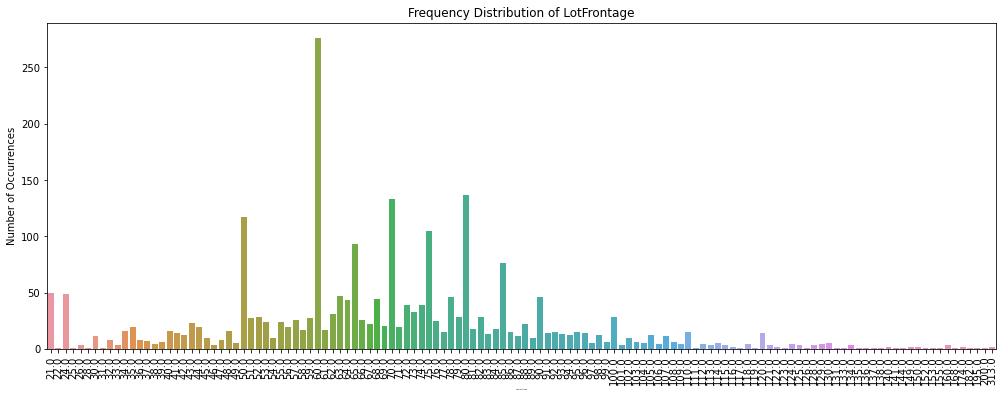

+-------+------------------+
|summary|       LotFrontage|
+-------+------------------+
|  count|              2433|
|   mean| 69.30579531442663|
| stddev|23.344904706927394|
|    min|                21|
|    max|               313|
+-------+------------------+



In [15]:
# vediamo la distribuzione dei valori per questa feature

LotFrontage_count = pivotDF.toPandas()['LotFrontage'].value_counts()
plt.subplots(figsize=(17, 6))
plt.xticks(rotation='90')
sns.barplot(x=LotFrontage_count.index, y=LotFrontage_count.values)
plt.title('Frequency Distribution of LotFrontage')
plt.ylabel('Number of Occurrences' )
plt.xlabel('LotFrontage', fontsize=2)
plt.show()

pivotDF.select('LotFrontage').describe().show()

In [16]:
# Andiamo a settare i valori nulli con il valore più frequente per questa feature

trainDF = trainDF.fillna(LotFrontage_count.index[0], subset=['LotFrontage'])
testDF = testDF.fillna(LotFrontage_count.index[0], subset=['LotFrontage'])

In [17]:
nullFeaturesTrainDF = spark.createDataFrame(null_value_count(trainDF), ['TRAIN Features with NA value', 'Count']).sort('Count', ascending=False)
nullFeaturesTrainDF.show()

nullFeaturesTestDF = spark.createDataFrame(null_value_count(testDF), ['TEST Features with NA value', 'Count']).sort('Count', ascending=False)
nullFeaturesTestDF.show()

+----------------------------+-----+
|TRAIN Features with NA value|Count|
+----------------------------+-----+
|                  GarageQual|   81|
|                  GarageCond|   81|
|                  GarageType|   81|
|                 GarageYrBlt|   81|
|                GarageFinish|   81|
|                BsmtFinType2|   38|
|                BsmtExposure|   38|
|                    BsmtQual|   37|
|                    BsmtCond|   37|
|                BsmtFinType1|   37|
|                  MasVnrArea|    8|
|                  MasVnrType|    8|
|                  Electrical|    1|
+----------------------------+-----+

+---------------------------+-----+
|TEST Features with NA value|Count|
+---------------------------+-----+
|                 GarageCond|   78|
|                GarageYrBlt|   78|
|                 GarageQual|   78|
|               GarageFinish|   78|
|                 GarageType|   76|
|                   BsmtCond|   45|
|                   BsmtQual|   44|
|         

In [18]:
# Se GarageArea e GarageCars sono uguali a 0, il garage non esiste. Riempiamo le righe che rispettano questa condizione settando
# alle features con valore None/0
trainDF = trainDF\
      .withColumn("GarageCond", when( ( col('GarageArea') == 0 ) & ( col('GarageCars')== 0 ), "None").otherwise(f.col('GarageCond')))\
		  .withColumn("GarageQual", when( ( col('GarageArea') == 0 ) & ( col('GarageCars')== 0 ), "None").otherwise(f.col('GarageQual')))\
			  	.withColumn("GarageFinish", when( ( col('GarageArea') == 0 ) & ( col('GarageCars')== 0 ), "None").otherwise(f.col('GarageFinish')))\
					.withColumn("GarageType", when( ( col('GarageArea') == 0 ) & ( col('GarageCars')== 0 ), "None").otherwise(f.col('GarageType')))\
						.withColumn("GarageYrBlt", when( ( col('GarageArea') == 0 ) & ( col('GarageCars')== 0 ), 0).otherwise(f.col('GarageYrBlt')))

testDF = testDF\
      .withColumn("GarageCond", when( ( col('GarageArea') == 0 ) & ( col('GarageCars')== 0 ), "None").otherwise(f.col('GarageCond')))\
		  .withColumn("GarageQual", when( ( col('GarageArea') == 0 ) & ( col('GarageCars')== 0 ), "None").otherwise(f.col('GarageQual')))\
			  	.withColumn("GarageFinish", when( ( col('GarageArea') == 0 ) & ( col('GarageCars')== 0 ), "None").otherwise(f.col('GarageFinish')))\
					.withColumn("GarageType", when( ( col('GarageArea') == 0 ) & ( col('GarageCars')== 0 ), "None").otherwise(f.col('GarageType')))\
						.withColumn("GarageYrBlt", when( ( col('GarageArea') == 0 ) & ( col('GarageCars')== 0 ), 0).otherwise(f.col('GarageYrBlt')))

In [19]:
# nel test set notiamo una conflitto tra il numero di valori mancanti in GarageType con le altre feature riferite sempre al Garage

garage_features = ['GarageYrBlt', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageArea', 'GarageCars']
testDF.where( ( col('GarageType').isNull() == False ) & (col('GarageFinish').isNull() == True )).select(garage_features).show()

+-----------+----------+------------+----------+----------+----------+----------+
|GarageYrBlt|GarageType|GarageFinish|GarageQual|GarageCond|GarageArea|GarageCars|
+-----------+----------+------------+----------+----------+----------+----------+
|       null|    Detchd|        null|      null|      null|       360|         1|
|       null|    Detchd|        null|      null|      null|      null|      null|
+-----------+----------+------------+----------+----------+----------+----------+



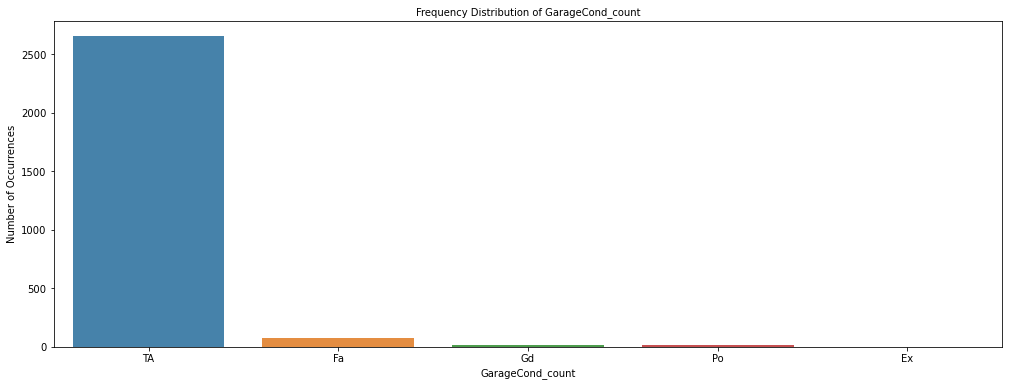

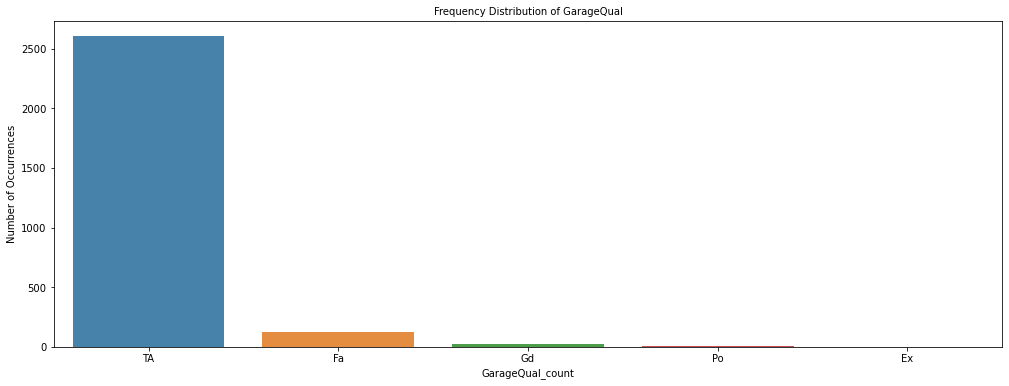

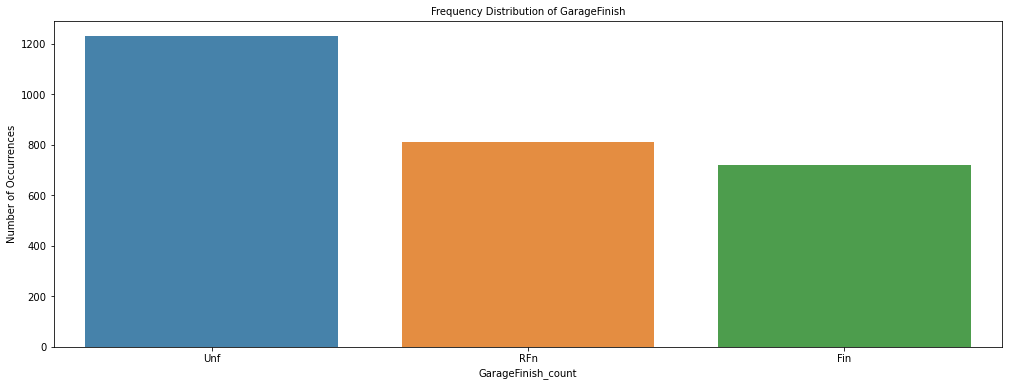

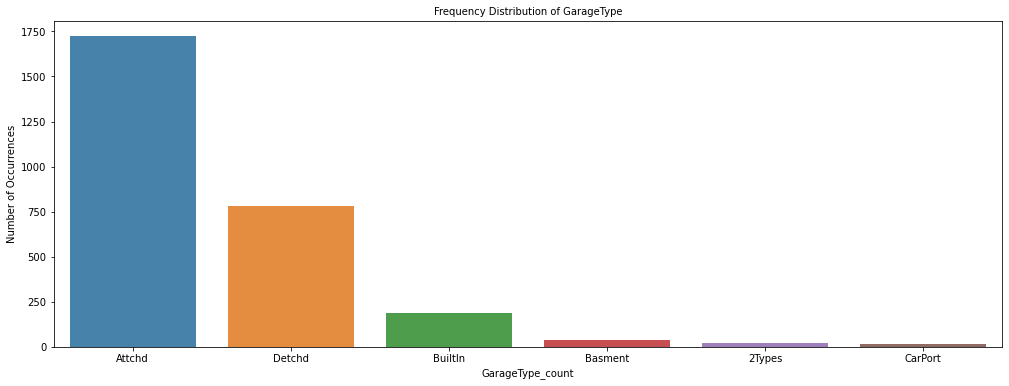

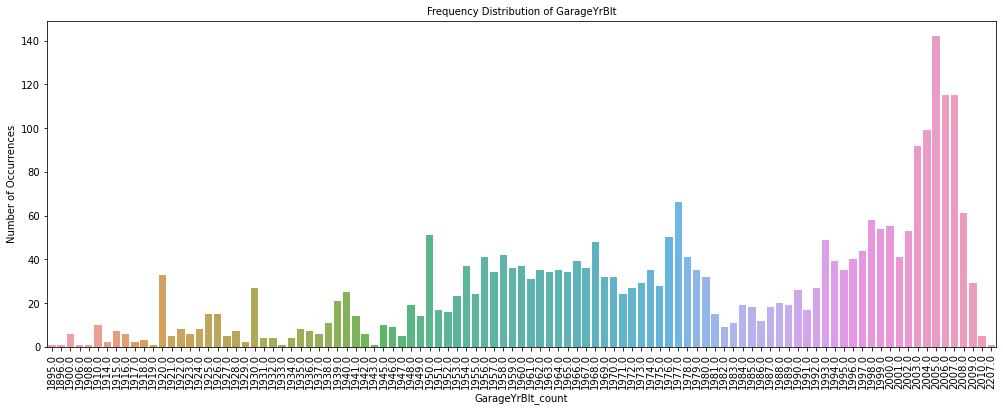

In [20]:
pivotPD = pivotDF.toPandas() # lo convertiamo per fare i grafici

# vediamo il valore più frequente di GarageCond
GarageCond_count = pivotPD['GarageCond'].value_counts()

plt.subplots(figsize=(17, 6))
sns.barplot(x=GarageCond_count.index, y=GarageCond_count.values, alpha=0.9)
plt.title('Frequency Distribution of GarageCond_count', fontsize=10)
plt.ylabel('Number of Occurrences', fontsize=10 )
plt.xlabel('GarageCond_count', fontsize=10)
plt.figure(1)

# vediamo il valore più frequente di GarageQual
GarageQual_count = pivotPD['GarageQual'].value_counts()

plt.subplots(figsize=(17, 6))
sns.barplot(x=GarageQual_count.index, y=GarageQual_count.values, alpha=0.9)
plt.title('Frequency Distribution of GarageQual', fontsize=10)
plt.ylabel('Number of Occurrences', fontsize=10 )
plt.xlabel('GarageQual_count', fontsize=10)
plt.figure(2)


# vediamo il valore più frequente di GarageFinish
GarageFinish_count = pivotPD['GarageFinish'].value_counts()

plt.subplots(figsize=(17, 6))
sns.barplot(x=GarageFinish_count.index, y=GarageFinish_count.values, alpha=0.9)
plt.title('Frequency Distribution of GarageFinish', fontsize=10)
plt.ylabel('Number of Occurrences', fontsize=10 )
plt.xlabel('GarageFinish_count', fontsize=10)
plt.figure(3)


# vediamo il valore più frequente di GarageYrBlt selezionando il GarageType come quella della nostra riga
GarageType_count = pivotPD['GarageType'].value_counts()

plt.subplots(figsize=(17, 6))
sns.barplot(x=GarageType_count.index, y=GarageType_count.values, alpha=0.9)
plt.title('Frequency Distribution of GarageType', fontsize=10)
plt.ylabel('Number of Occurrences', fontsize=10 )
plt.xlabel('GarageType_count', fontsize=10)
plt.figure(4)


# vediamo il valore più frequente di GarageYrBlt selezionando il GarageType come quella della nostra riga
GarageYrBlt_count = pivotPD['GarageYrBlt'].value_counts()

plt.subplots(figsize=(17, 6))
sns.barplot(x=GarageYrBlt_count.index, y=GarageYrBlt_count.values, alpha=0.9)
plt.title('Frequency Distribution of GarageYrBlt', fontsize=10)
plt.ylabel('Number of Occurrences', fontsize=10 )
plt.xlabel('GarageYrBlt_count', fontsize=10)
plt.xticks(rotation='90')
plt.figure(5)

plt.show()

In [21]:
# calcoliamo le statistiche
pivotDF.select(garage_features).describe().show()

+-------+------------------+----------+------------+----------+----------+------------------+------------------+
|summary|       GarageYrBlt|GarageType|GarageFinish|GarageQual|GarageCond|        GarageArea|        GarageCars|
+-------+------------------+----------+------------+----------+----------+------------------+------------------+
|  count|              2760|      2762|        2760|      2760|      2760|              2918|              2918|
|   mean|1978.1134057971014|      null|        null|      null|      null| 472.8745716244003|1.7666209732693625|
| stddev|25.574284723905112|      null|        null|      null|      null|215.39481499352166|0.7616243225993496|
|    min|              1895|    2Types|         Fin|        Ex|        Ex|                 0|                 0|
|    max|              2207|    Detchd|         Unf|        TA|        TA|              1488|                 5|
+-------+------------------+----------+------------+----------+----------+------------------+---

In [22]:
avgGarageArea = pivotDF.select(avg(pivotDF.GarageArea)).collect()[0][0]
avgGarageCars = pivotDF.select(avg(pivotDF.GarageCars)).collect()[0][0]
avgGarageYrBlt = pivotDF.select(avg(pivotDF.GarageYrBlt)).collect()[0][0]

print(f'Avg GarageArea: {avgGarageArea}\nAvg GarageCars: {avgGarageCars}\nAvg GarageYrBlt: {avgGarageYrBlt}')

Avg GarageArea: 472.8745716244003
Avg GarageCars: 1.7666209732693625
Avg GarageYrBlt: 1978.1134057971014


In [23]:
# riempiamo le feature mancanti con i valori medi e frequenti calcolati precedentemente

testDF = testDF\
	.fillna(avgGarageYrBlt, subset='GarageYrBlt')\
		.fillna(GarageFinish_count.index[0], subset='GarageFinish')\
			.fillna(GarageQual_count.index[0], subset='GarageQual')\
				.fillna(GarageCond_count.index[0], subset='GarageCond')\
					.fillna(GarageType_count.index[0], subset='GarageType')\
						.fillna(avgGarageArea, subset='GarageArea')\
							.fillna(avgGarageCars, subset='GarageCars')

In [24]:
nullFeaturesTrainDF = spark.createDataFrame(null_value_count(trainDF), ['TRAIN Features with NA value', 'Count']).sort('Count', ascending=False)
nullFeaturesTrainDF.show()

nullFeaturesTestDF = spark.createDataFrame(null_value_count(testDF), ['TEST Features with NA value', 'Count']).sort('Count', ascending=False)
nullFeaturesTestDF.show()

+----------------------------+-----+
|TRAIN Features with NA value|Count|
+----------------------------+-----+
|                BsmtFinType2|   38|
|                BsmtExposure|   38|
|                    BsmtQual|   37|
|                    BsmtCond|   37|
|                BsmtFinType1|   37|
|                  MasVnrArea|    8|
|                  MasVnrType|    8|
|                  Electrical|    1|
+----------------------------+-----+

+---------------------------+-----+
|TEST Features with NA value|Count|
+---------------------------+-----+
|                   BsmtCond|   45|
|                   BsmtQual|   44|
|               BsmtExposure|   44|
|               BsmtFinType2|   42|
|               BsmtFinType1|   42|
|                 MasVnrType|   16|
|                 MasVnrArea|   15|
|                   MSZoning|    4|
|                 Functional|    2|
|                  Utilities|    2|
|               BsmtHalfBath|    2|
|               BsmtFullBath|    2|
|              

In [25]:
bsmt_features = ['BsmtQual','BsmtCond', 'BsmtExposure', 'BsmtFinType2', 'BsmtFinType1', 'TotalBsmtSF', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF']
testDF.select(bsmt_features).where(col('BsmtFinSF1').isNull() == True).show()

+--------+--------+------------+------------+------------+-----------+------------+----------+------------+----------+---------+
|BsmtQual|BsmtCond|BsmtExposure|BsmtFinType2|BsmtFinType1|TotalBsmtSF|BsmtFinType1|BsmtFinSF1|BsmtFinType2|BsmtFinSF2|BsmtUnfSF|
+--------+--------+------------+------------+------------+-----------+------------+----------+------------+----------+---------+
|    null|    null|        null|        null|        null|       null|        null|      null|        null|      null|     null|
+--------+--------+------------+------------+------------+-----------+------------+----------+------------+----------+---------+



In [26]:
# se TotalBsmtSF è 0 vuol dire che non c'è nessun seminterrato, quindi setteremo le features nulle correlate a None/0

trainDF = trainDF\
      .withColumn("BsmtQual", when( ( col('TotalBsmtSF') == 0 ) , "None").otherwise(f.col('BsmtQual')))\
		    .withColumn("BsmtCond", when( ( col('TotalBsmtSF') == 0 ) , "None").otherwise(f.col('BsmtCond')))\
			    .withColumn("BsmtExposure", when( ( col('TotalBsmtSF') == 0 ), "None").otherwise(f.col('BsmtExposure')))\
				    .withColumn("BsmtFinType2", when( ( col('TotalBsmtSF') == 0 ), 0).otherwise(f.col('BsmtFinType2')))\
					    .withColumn("BsmtFinType1", when( ( col('TotalBsmtSF') == 0 ), 0).otherwise(f.col('BsmtFinType1')))


testDF = testDF\
      .withColumn("BsmtQual", when( ( col('TotalBsmtSF') == 0 ), "None").otherwise(f.col('BsmtQual')))\
		  .withColumn("BsmtCond", when( ( col('TotalBsmtSF') == 0 ), "None").otherwise(f.col('BsmtCond')))\
			  .withColumn("BsmtExposure", when( ( col('TotalBsmtSF') == 0 ), "None").otherwise(f.col('BsmtExposure')))\
				  .withColumn("BsmtFinType2", when( ( col('TotalBsmtSF') == 0 ), 0).otherwise(f.col('BsmtFinType2')))\
					  .withColumn("BsmtFinType1", when( ( col('TotalBsmtSF') == 0 ), 0).otherwise(f.col('BsmtFinType1')))\
					  		.withColumn("BsmtUnfSF", when( ( col('TotalBsmtSF') == 0 ), 0).otherwise(f.col('BsmtUnfSF')))\
								.withColumn("BsmtFinSF2", when( ( col('TotalBsmtSF') == 0 ), 0).otherwise(f.col('BsmtFinSF2')))\
									.withColumn("BsmtHalfBath", when( ( col('TotalBsmtSF') == 0 ), 0).otherwise(f.col('BsmtHalfBath')))\
										.withColumn("BsmtFullBath", when( ( col('TotalBsmtSF') == 0 ), 0).otherwise(f.col('BsmtFullBath')))

In [27]:
nullFeaturesTrainDF = spark.createDataFrame(null_value_count(trainDF), ['TRAIN Features with NA value', 'Count']).sort('Count', ascending=False)
nullFeaturesTrainDF.show()

nullFeaturesTestDF = spark.createDataFrame(null_value_count(testDF), ['TEST Features with NA value', 'Count']).sort('Count', ascending=False)
nullFeaturesTestDF.show()

+----------------------------+-----+
|TRAIN Features with NA value|Count|
+----------------------------+-----+
|                  MasVnrArea|    8|
|                  MasVnrType|    8|
|                BsmtExposure|    1|
|                  Electrical|    1|
|                BsmtFinType2|    1|
+----------------------------+-----+

+---------------------------+-----+
|TEST Features with NA value|Count|
+---------------------------+-----+
|                 MasVnrType|   16|
|                 MasVnrArea|   15|
|                   BsmtCond|    4|
|                   MSZoning|    4|
|               BsmtExposure|    3|
|                   BsmtQual|    3|
|                  Utilities|    2|
|                 Functional|    2|
|               BsmtHalfBath|    1|
|                   SaleType|    1|
|                KitchenQual|    1|
|                  BsmtUnfSF|    1|
|                TotalBsmtSF|    1|
|               BsmtFullBath|    1|
|                 BsmtFinSF2|    1|
|                 

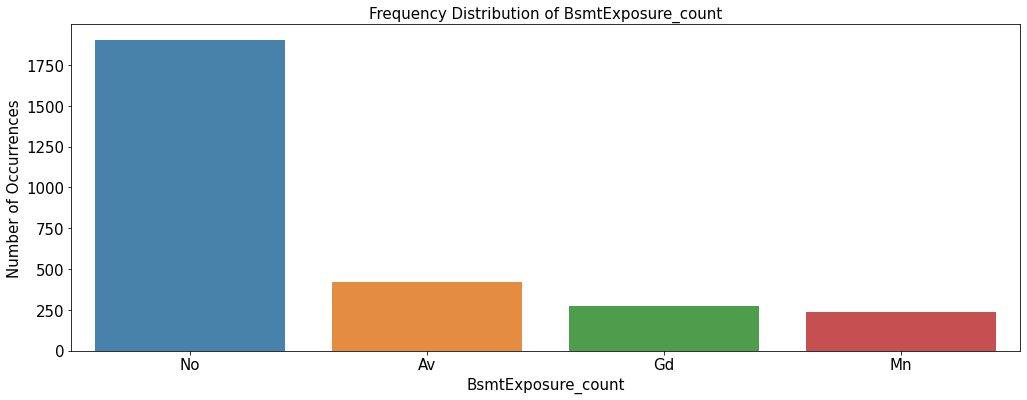

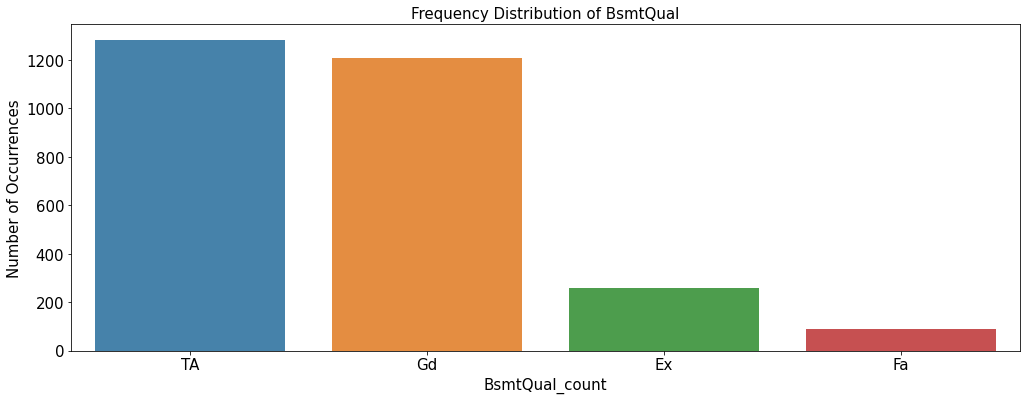

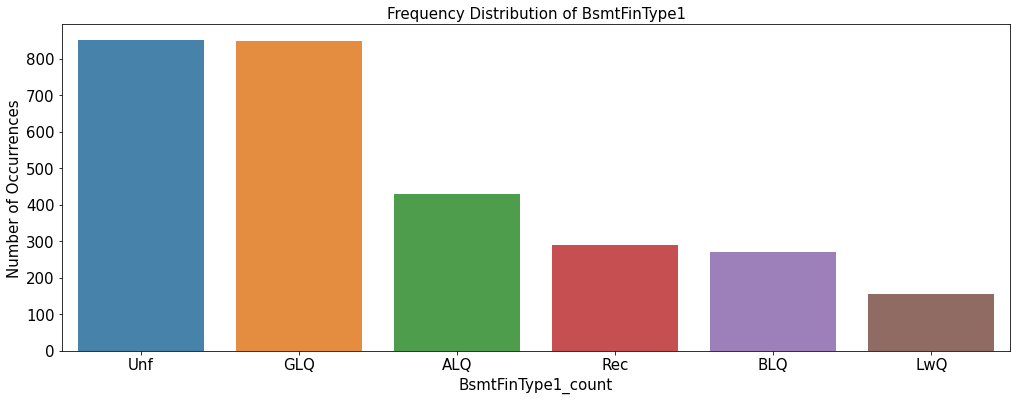

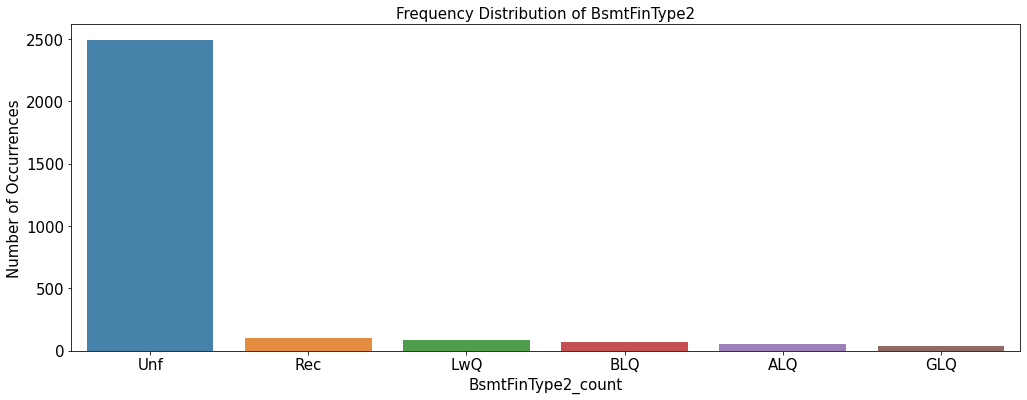

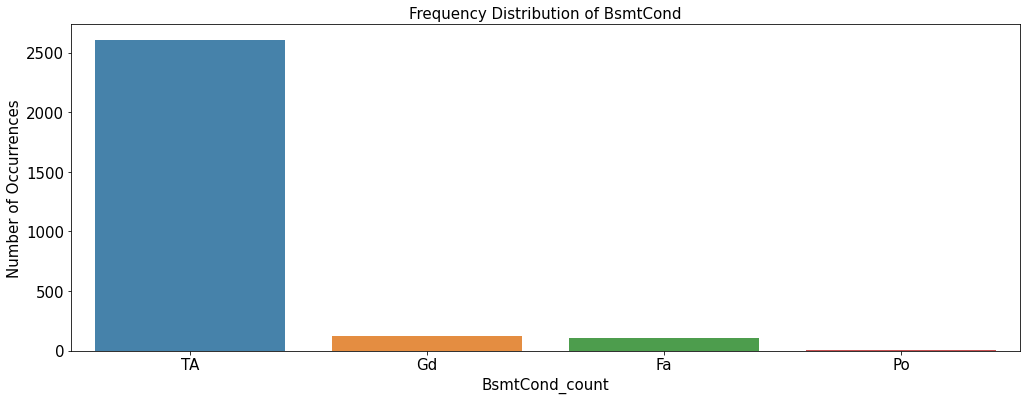

In [28]:
#andremo a riempire le feature mancanti con i valori più frequenti o medi.

# vediamo il valore più frequente di BsmtExposure
BsmtExposure_count = pivotPD['BsmtExposure'].value_counts()

plt.subplots(figsize=(17, 6))
sns.barplot(x=BsmtExposure_count.index, y=BsmtExposure_count.values, alpha=0.9)
plt.title('Frequency Distribution of BsmtExposure_count', fontsize=15)
plt.ylabel('Number of Occurrences', fontsize=15)
plt.xlabel('BsmtExposure_count', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.figure(1)

# vediamo il valore più frequente di BsmtQual
BsmtQual_count = pivotPD['BsmtQual'].value_counts()

plt.subplots(figsize=(17, 6))
sns.barplot(x=BsmtQual_count.index, y=BsmtQual_count.values, alpha=0.9)
plt.title('Frequency Distribution of BsmtQual', fontsize=15)
plt.ylabel('Number of Occurrences', fontsize=15 )
plt.xlabel('BsmtQual_count', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.figure(2)


# vediamo il valore più frequente di BsmtFinType1
BsmtFinType1_count = pivotPD['BsmtFinType1'].value_counts()

plt.subplots(figsize=(17, 6))
sns.barplot(x=BsmtFinType1_count.index, y=BsmtFinType1_count.values, alpha=0.9)
plt.title('Frequency Distribution of BsmtFinType1', fontsize=15)
plt.ylabel('Number of Occurrences', fontsize=15 )
plt.xlabel('BsmtFinType1_count', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.figure(3)


# vediamo il valore più frequente di BsmtFinType2
BsmtFinType2_count = pivotPD['BsmtFinType2'].value_counts()

plt.subplots(figsize=(17, 6))
sns.barplot(x=BsmtFinType2_count.index, y=BsmtFinType2_count.values, alpha=0.9)
plt.title('Frequency Distribution of BsmtFinType2', fontsize=15)
plt.ylabel('Number of Occurrences', fontsize=15 )
plt.xlabel('BsmtFinType2_count', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.figure(4)

# vediamo il valore più frequente di BsmtFinType2
BsmtCond_count = pivotPD['BsmtCond'].value_counts()

plt.subplots(figsize=(17, 6))
sns.barplot(x=BsmtCond_count.index, y=BsmtCond_count.values, alpha=0.9)
plt.title('Frequency Distribution of BsmtCond', fontsize=15)
plt.ylabel('Number of Occurrences', fontsize=15 )
plt.xlabel('BsmtCond_count', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.figure(4)
plt.show()



In [29]:
#calcoliamo le statistiche
pivotDF.select(bsmt_features).describe().show()

+-------+--------+--------+------------+------------+------------+------------------+------------+------------------+------------+-----------------+-----------------+
|summary|BsmtQual|BsmtCond|BsmtExposure|BsmtFinType2|BsmtFinType1|       TotalBsmtSF|BsmtFinType1|        BsmtFinSF1|BsmtFinType2|       BsmtFinSF2|        BsmtUnfSF|
+-------+--------+--------+------------+------------+------------+------------------+------------+------------------+------------+-----------------+-----------------+
|  count|    2838|    2837|        2837|        2839|        2840|              2918|        2840|              2918|        2839|             2918|             2918|
|   mean|    null|    null|        null|        null|        null|1051.7775873886224|        null| 441.4232350925291|        null|49.58224811514736|560.7721041809458|
| stddev|    null|    null|        null|        null|        null| 440.7662581159385|        null|455.61082587029176|        null|169.2056110999798|439.5436594234397

In [30]:
avgBsmtFinSF1 = pivotDF.select(avg(pivotDF.BsmtFinSF1)).collect()[0][0]
avgBsmtFinSF2 = pivotDF.select(avg(pivotDF.BsmtFinSF2)).collect()[0][0]
avgBsmtUnfSF = pivotDF.select(avg(pivotDF.BsmtUnfSF)).collect()[0][0]
avgTotalBsmtSF= pivotDF.select(avg(pivotDF.TotalBsmtSF)).collect()[0][0]
avgBsmtHalfBath = pivotDF.select(avg(pivotDF.BsmtHalfBath)).collect()[0][0]
avgBsmtFullBath= pivotDF.select(avg(pivotDF.BsmtFullBath)).collect()[0][0]

In [31]:
# riempiamo le feature mancanti con i valori medi e frequenti calcolati precedentemente
trainDF = trainDF\
	.fillna(BsmtExposure_count.index[0], subset='BsmtExposure')\
		.fillna(BsmtFinType2_count.index[0], subset='BsmtFinType2')


testDF = testDF\
	.fillna(BsmtExposure_count.index[0], subset='BsmtExposure')\
		.fillna(BsmtQual_count.index[0], subset='BsmtQual')\
			.fillna(BsmtCond_count.index[0], subset='BsmtCond')\
				.fillna(BsmtFinType2_count.index[0], subset='BsmtFinType2')\
					.fillna(BsmtFinType1_count.index[0], subset='BsmtFinType1')\
						.fillna(avgBsmtFinSF1, subset='BsmtFinSF1')\
							.fillna(avgTotalBsmtSF, subset='TotalBsmtSF')\
								.fillna(avgBsmtFinSF2, subset='BsmtFinSF2')\
									.fillna(avgBsmtUnfSF, subset='BsmtUnfSF')\
										.fillna(avgBsmtHalfBath, subset='BsmtHalfBath')\
											.fillna(avgBsmtFullBath, subset='BsmtFullBath')

In [32]:
nullFeaturesTrainDF = spark.createDataFrame(null_value_count(trainDF), ['TRAIN Features with NA value', 'Count']).sort('Count', ascending=False)
nullFeaturesTrainDF.show()

nullFeaturesTestDF = spark.createDataFrame(null_value_count(testDF), ['TEST Features with NA value', 'Count']).sort('Count', ascending=False)
nullFeaturesTestDF.show()

+----------------------------+-----+
|TRAIN Features with NA value|Count|
+----------------------------+-----+
|                  MasVnrType|    8|
|                  MasVnrArea|    8|
|                  Electrical|    1|
+----------------------------+-----+

+---------------------------+-----+
|TEST Features with NA value|Count|
+---------------------------+-----+
|                 MasVnrType|   16|
|                 MasVnrArea|   15|
|                   MSZoning|    4|
|                  Utilities|    2|
|                 Functional|    2|
|                Exterior1st|    1|
|                KitchenQual|    1|
|                   SaleType|    1|
|                Exterior2nd|    1|
+---------------------------+-----+



In [33]:
#notiamo che nel test set c'è un'incongruenza tra MasVnrArea e MasVnrType. Controlliamo

trainDF.select('MasVnrType', 'MasVnrArea' ).where(col('MasVnrType').isNull()== True).show()
testDF.select('MasVnrType', 'MasVnrArea' ).where(col('MasVnrType').isNull()== True).show()


+----------+----------+
|MasVnrType|MasVnrArea|
+----------+----------+
|      null|      null|
|      null|      null|
|      null|      null|
|      null|      null|
|      null|      null|
|      null|      null|
|      null|      null|
|      null|      null|
+----------+----------+

+----------+----------+
|MasVnrType|MasVnrArea|
+----------+----------+
|      null|      null|
|      null|      null|
|      null|      null|
|      null|      null|
|      null|      null|
|      null|      null|
|      null|      null|
|      null|      null|
|      null|      null|
|      null|      null|
|      null|      null|
|      null|      null|
|      null|       198|
|      null|      null|
|      null|      null|
|      null|      null|
+----------+----------+



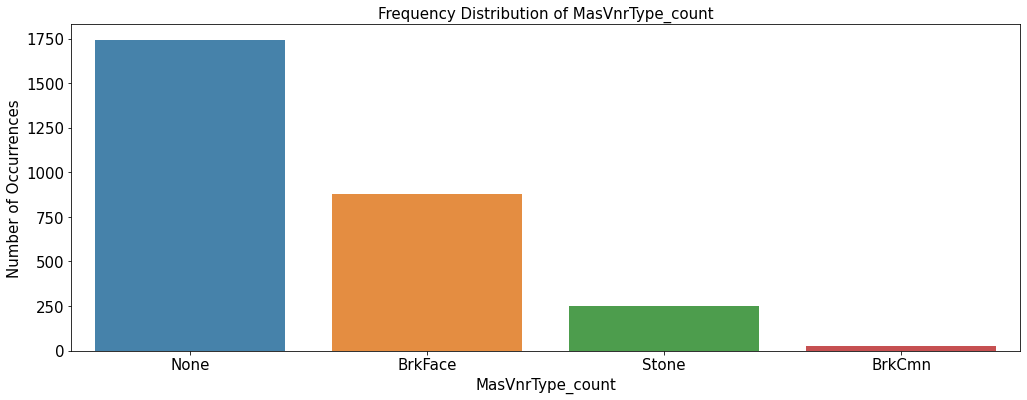

In [34]:
#andremo a riempire le feature mancanti con i valori più frequenti o medi.

# vediamo il valore più frequente di BsmtExposure
MasVnrType_count = pivotPD['MasVnrType'].value_counts()

plt.subplots(figsize=(17, 6))
sns.barplot(x=MasVnrType_count.index, y=MasVnrType_count.values, alpha=0.9)
plt.title('Frequency Distribution of MasVnrType_count', fontsize=15)
plt.ylabel('Number of Occurrences', fontsize=15)
plt.xlabel('MasVnrType_count', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.figure(1)

plt.show()

In [35]:
# Avendo un'area maggiore di 0 vuole dire che esistono opere murarie, inseriamo il secondo valore più frequente dato che il primo è None
testDF = testDF\
      .withColumn("MasVnrType", when( (col('MasVnrArea') > 0) & (col('MasVnrType').isNull() == True), MasVnrType_count.index[1]).otherwise(f.col('MasVnrType'))) 

In [36]:
# riempiamo i restanti valori nulli con None/0

trainDF = trainDF\
	.fillna('None', subset='MasVnrType')\
		.fillna(0, subset='MasVnrArea')

testDF = testDF\
	.fillna('None', subset='MasVnrType')\
		.fillna(0, subset='MasVnrArea')

In [37]:
nullFeaturesTrainDF = spark.createDataFrame(null_value_count(trainDF), ['TRAIN Features with NA value', 'Count']).sort('Count', ascending=False)
nullFeaturesTrainDF.show()

nullFeaturesTestDF = spark.createDataFrame(null_value_count(testDF), ['TEST Features with NA value', 'Count']).sort('Count', ascending=False)
nullFeaturesTestDF.show()

+----------------------------+-----+
|TRAIN Features with NA value|Count|
+----------------------------+-----+
|                  Electrical|    1|
+----------------------------+-----+

+---------------------------+-----+
|TEST Features with NA value|Count|
+---------------------------+-----+
|                   MSZoning|    4|
|                 Functional|    2|
|                  Utilities|    2|
|                Exterior1st|    1|
|                   SaleType|    1|
|                Exterior2nd|    1|
|                KitchenQual|    1|
+---------------------------+-----+



In [38]:
#riempiamo le restanti feature con i valori più frequenti
Electrical_count = pivotPD['Electrical'].value_counts()
MSZoning_count = pivotPD['MSZoning'].value_counts()
Functional_count = pivotPD['Functional'].value_counts()
Utilities_count = pivotPD['Utilities'].value_counts()
SaleType_count = pivotPD['SaleType'].value_counts()
Exterior1st_count = pivotPD['Exterior1st'].value_counts()
Exterior2nd_count = pivotPD['Exterior2nd'].value_counts()

In [39]:
trainDF = trainDF.fillna(Electrical_count.index[0], subset='Electrical')

testDF = testDF\
	.fillna(MSZoning_count.index[0], subset='MSZoning')\
		.fillna(Functional_count.index[0], subset='Functional')\
			.fillna(Utilities_count.index[0], subset='Utilities')\
					.fillna(SaleType_count.index[0], subset='SaleType')\
						.fillna(Exterior1st_count.index[0], subset='Exterior1st')\
								.fillna(Exterior2nd_count.index[0], subset='Exterior2nd')

In [40]:
# controllo se è presente la cucina
testDF.select('KitchenAbvGr', 'KitchenQual' ).where( col('KitchenQual').isNull() == True ).show()

+------------+-----------+
|KitchenAbvGr|KitchenQual|
+------------+-----------+
|           1|       null|
+------------+-----------+



In [41]:
# dato che la cucina è presente inseriamo per KitchenQual il valore più frequente
KitchenQual_count = pivotPD['KitchenQual'].value_counts()
testDF = testDF.fillna(KitchenQual_count.index[0], subset='KitchenQual')

In [44]:
null_value_count(trainDF)
null_value_count(testDF)


[]

In [77]:
#dividiamo le features in base al tipo di dato 

str_features = [] 
int_features = []

for col in  trainDF.dtypes:
    if col[1] == 'string':
        str_features += [col[0]]
    else:
        int_features += [col[0]]


int_features.remove('SalePrice')
print(f'str_features : {str_features}\n')
print(f'int_features: {int_features}')


str_features : ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']

int_features: ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch

# StringIndexer
L'attività più comune per le caratteristiche categoriali è l'indicizzazione. L'indicizzazione converte una categoria variabile in una colonna a una numerica che puoi collegare ad algoritmi di apprendimento automatico.

Anche se questo è concettualmente semplice, ci sono alcune catture che è importante tenere a mente che Spark può farlo in modo stabile e ripetibile.

In generale, consigliamo di reindicizzare ogni variabile categoriale durante la pre-elaborazione solo per amore della coerenza. Questo può essere utile per mantenere i tuoi modelli a lungo termine come i tuoi le pratiche di codifica possono cambiare nel tempo.

Strind Indexer
Il modo più semplice per indicizzare è tramite StringIndexer, che mappa le stringhe su numeri diversi ID. StringIndexer di Spark crea anche metadati allegati a DataFrame che specificano cosa
gli ingressi corrispondono a quali uscite.

Questo ci consente in seguito di recuperare gli input dai rispettivi valori di indice.

In [81]:
#creaimo degli stages da inserire poi direttamente nella pipeline
pipeline_stages = []

In [82]:
labelDF = trainDF[str_features].unionByName(testDF[str_features])

string_indexers = [StringIndexer(inputCol=column, outputCol=column+'_index', handleInvalid='keep') for column in str_features]

pipeline_stages.append(string_indexers)


# Index to String

Quando ispezioni i tuoi risultati di machine learning, probabilmente vorrai eseguire nuovamente la mappatura a valori originari.

Poiché i modelli di classificazione MLlib effettuano previsioni utilizzando i valori indicizzati,
questa conversione è utile per riconvertire le previsioni del modello (indici) nell'originale
categorie.

Possiamo farlo con IndexToString. Noterai che non dobbiamo inserire il nostro valore alla chiave String; MLlib di Spark mantiene questi metadati per te. Puoi facoltativamente specificare le uscite.

In [83]:
from pyspark.ml.feature import IndexToString

label_reverse = [IndexToString(inputCol=column, outputCol=column+'_reverse') for column in str_features]

#non serve dato che devo predire un valore e non una stringa
# pipeline_stages.append(label_reverse)


# VectorAssembler 
È un trasformatore che combina un determinato elenco di colonne in un'unica colonna vettoriale. È utile per combinare funzionalità grezze e funzionalità generate da diversi trasformatori di funzionalità in un unico vettore di funzionalità, al fine di addestrare modelli ML come la regressione logistica e gli alberi decisionali. VectorAssembler accetta i seguenti tipi di colonne di input: tutti i tipi numerici, il tipo booleano e il tipo vettoriale. In ogni riga, i valori delle colonne di input verranno concatenati in un vettore nell'ordine specificato.

In [84]:
assembler = VectorAssembler().setInputCols(str_features + int_features).setOutputCol("Features").setHandleInvalid("keep")

pipeline_stages.append(assembler)

In [ ]:
plt.figure(figsize=(15, 12), dpi = 600) 
corr =labelDF.toPandas().corr()
sns.heatmap(corr, annot=True, annot_kws={"fontsize":4}, square=True).set_title('Features Correlating', fontdict={'fontsize':16}, pad=16);

In [85]:
# vediamo la correlazione solo con il prezzo di vendita

corrSP = labelDF.toPandas().corr()[['SalePrice']].sort_values(by='SalePrice', ascending=False)

plt.figure(figsize=(2, 4), dpi = 200) 
sns.set(font_scale = 0.4)

sns.heatmap(corrSP, annot=True, annot_kws={"fontsize":4},).set_title('Features Correlating with Sales Price', fontdict={'fontsize':10}, pad=16);

KeyError: "None of [Index(['SalePrice'], dtype='object')] are in the [columns]"

In [ ]:
# prendiamo le feature che hanno un valore di correlazione >= 0.5 ed eliminiamo la colonna SalePrice che avrà valore 1 
featuresSelect = corrSP['SalePrice'][ corrSP['SalePrice'] >= 0.5].drop('SalePrice')

print(featuresSelect)